Shape: (181, 48)
Columns: ['Activity ID', 'Activity Date', 'Activity Name', 'Activity Type', 'duration', 'distance', 'Max Heart Rate', 'Relative Effort', 'Commute', 'Athlete Weight', 'Bike Weight', 'Moving Time', 'Max Speed', 'Average Speed', 'elevation_gain'] ...


,Activity ID,Activity Date,Activity Name,Activity Type,duration,distance,Max Heart Rate,Relative Effort,Commute,Athlete Weight,...,Maximum Power 30s,Maximum Power 1.0min,Maximum Power 5.0min,Maximum Power 10.0min,Maximum Power 20.0min,Maximum Power 30.0min,Maximum Power 1.0 hr,Maximum Power 1.5 hr,Maximum Power 2.0 hr,ftp_values
0,2929442069,"13 Dec 2019, 01:46:07",Lunch Ride,Ride,3859,22.97,139.0,11.0,False,84.0,...,342.1,221.2,162.2,136.3,120.8,109.8,105.4,0.0,0.0,114.760
1,2945780637,"20 Dec 2019, 23:05:01",Morning Ride,Ride,4852,29.65,133.0,12.0,False,84.0,...,236.1,184.3,150.6,131.4,122.1,120.3,115.6,0.0,0.0,115.995
2,2948028275,"21 Dec 2019, 23:25:29",Morning Ride,Ride,5817,32.38,139.0,19.0,False,84.0,...,265.1,213.3,146.2,135.1,127.5,125.5,110.2,104.7,0.0,121.125
3,2952462113,"24 Dec 2019, 01:19:17",Lunch Ride,Ride,3851,21.68,140.0,11.0,False,84.0,...,303.1,262.0,161.9,146.7,139.7,134.0,112.3,0.0,0.0,132.715
4,2956494096,"26 Dec 2019, 00:09:08",Lunch Ride,Ride,5843,32.36,131.0,14.0,False,80.0,...,243.9,208.3,134.7,124.0,119.4,115.5,99.8,96.9,0.0,113.430



After cleaning:
Rows: 181


,distance_km,elevation_gain,climb_per_km,grade_percent
count,181.000000,181.000000,181.000000,181.000000
mean,54.417569,85.366937,1.675568,0.167557
std,28.127591,107.415028,2.081849,0.208185
min,10.960000,0.000000,0.000000,0.000000
25%,38.110000,10.000000,0.199962,0.019996
50%,50.890000,34.799988,0.818275,0.081827
75%,60.970000,157.000000,2.617047,0.261705
max,180.080000,567.370667,11.254613,1.125461


Linear Regression (test):  MAE=8.19 min | RMSE=10.20 min | R²=0.981
Ridge (CV) (test):  MAE=8.99 min | RMSE=11.07 min | R²=0.978

Random Forest (tuned) test
RF:  MAE=8.31 min | RMSE=10.50 min | R²=0.980
Best RF params: {'max_depth': 17, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 262}

Gradient Boosting (tuned) test
GBR:  MAE=7.86 min | RMSE=9.70 min | R²=0.983
Best GBR params: {'learning_rate': 0.012219650999291443, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 415, 'subsample': 0.808613223758933}

Winner: GradientBoosting
Winner (test):  MAE=7.86 min | RMSE=9.70 min | R²=0.983


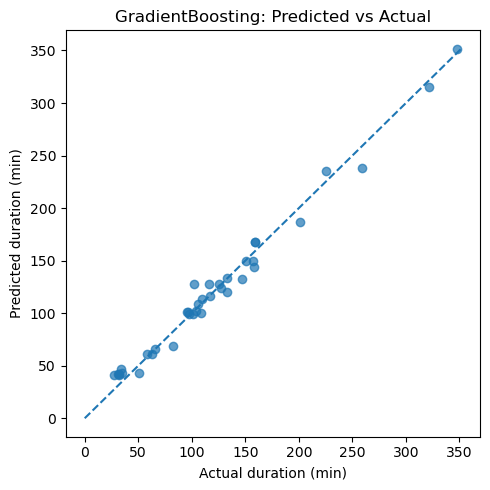


Feature importance (descending):
distance_km       0.974396
elevation_gain    0.012823
grade_percent     0.006782
climb_per_km      0.005998
dtype: float64


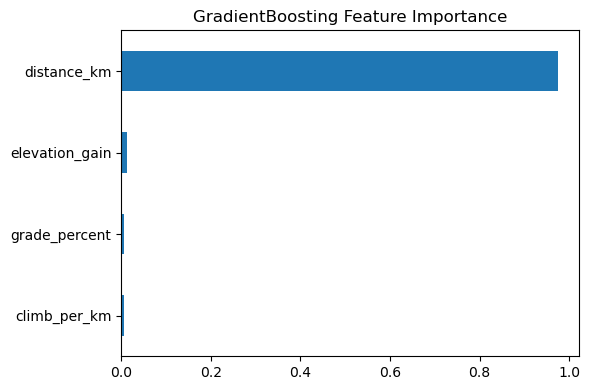


Saved tuned model → artifacts\duration_gradientboosting_tuned.pkl
Saved modeling table → artifacts\cycling_modeling_features_v1.csv

Saved unified inference pipeline → artifacts\duration_pipeline_v1.pkl
Saved quantile pipelines → artifacts\duration_pipeline_quantiles_v1.pkl

Example prediction: {'pred_min': 141.0567060353511, 'pi_10': 118.68737037639359, 'pi_90': 157.49249967147392}


In [2]:
# Cycling Duration Prediction 

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, Tuple

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import randint, uniform, loguniform
import joblib

RANDOM_STATE = 123
np.random.seed(RANDOM_STATE)

RAW_URL = (
    "https://raw.githubusercontent.com/"
    "Redback-Operations/redback-fit-sports-performance/"
    "main/Cycling%20Analysis/data/cycling_data_with_ftp.csv"
)
LOCAL_FALLBACK = "cycling_data_with_ftp.csv"  
ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

def infer_duration_hours(s: pd.Series) -> pd.Series:
    """
    Convert raw duration to hours (handles seconds/minutes/hours heuristically).
    """
    s = pd.to_numeric(s, errors="coerce")
    med = s.dropna().median()
    if pd.isna(med):
        return s
    if 1000 < med < 100000:   # seconds -> hours
        return s / 3600.0
    if 100 < med < 1000:      # minutes -> hours
        return s / 60.0
    return s.astype(float)    # already hours

def infer_distance_km(s: pd.Series) -> pd.Series:
    """
    Convert raw distance to kilometers (handles meters vs km).
    """
    s = pd.to_numeric(s, errors="coerce")
    med = s.dropna().median()
    if pd.isna(med):
        return s
    return (s / 1000.0) if med > 100 else s.astype(float)

def load_raw_df() -> pd.DataFrame:
    """
    Load the dataset (prefers RAW_URL; falls back to local if available).
    """
    try:
        df = pd.read_csv(RAW_URL)
    except Exception:
        if os.path.exists(LOCAL_FALLBACK):
            df = pd.read_csv(LOCAL_FALLBACK)
        else:
            raise
    # Standardize a few column names we rely on
    df = df.rename(columns={
        "Elapsed Time": "duration",
        "Distance": "distance",
        "Elevation Gain": "elevation_gain",
        "Date": "date"  # if present
    })
    return df

def make_features(raw: pd.DataFrame) -> pd.DataFrame:
    """
    Build leakage-free features from raw input columns.
    Adds:
      - distance_km
      - elevation_gain (as numeric; NaN -> 0)
      - climb_per_km (m per km)
      - grade_percent
      - intensity_factor (avg_power / FTP) if both exist
    """
    d = raw.copy()
    d["distance_km"] = infer_distance_km(d["distance"])
    d["elevation_gain"] = pd.to_numeric(d["elevation_gain"], errors="coerce").fillna(0)

    # Optional power-based intensity
    if {"Average Power", "FTP"} <= set(d.columns):
        d["avg_power"] = pd.to_numeric(d["Average Power"], errors="coerce")
        d["ftp"] = pd.to_numeric(d["FTP"], errors="coerce")
        d["intensity_factor"] = np.where(d["ftp"] > 0, d["avg_power"] / d["ftp"], np.nan)

    d["climb_per_km"] = np.where(d["distance_km"] > 0, d["elevation_gain"] / d["distance_km"], np.nan)
    d["grade_percent"] = np.where(
        d["distance_km"] > 0, (d["elevation_gain"] / (d["distance_km"] * 1000.0)) * 100.0, np.nan
    )

    # Final feature set
    features = ["distance_km", "elevation_gain", "climb_per_km", "grade_percent"]
    if "intensity_factor" in d.columns:
        features.append("intensity_factor")

    return d[features]

def metrics(y_true, y_pred) -> Dict[str, float]:
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "R2": r2_score(y_true, y_pred),
    }

def print_metrics(label: str, m: Dict[str, float]) -> None:
    print(f"{label}:  MAE={m['MAE']:.2f} min | RMSE={m['RMSE']:.2f} min | R²={m['R2']:.3f}")

def plot_pred_vs_actual(y_true, y_pred, title="Predicted vs Actual (min)") -> None:
    plt.figure(figsize=(5, 5))
    plt.scatter(y_true, y_pred, alpha=0.7)
    lim = [0, max(float(np.max(y_true)), float(np.max(y_pred)))]
    plt.plot(lim, lim, "--")
    plt.xlabel("Actual duration (min)")
    plt.ylabel("Predicted duration (min)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Loading & a quick EDA snapshot 
df = load_raw_df()
print("Shape:", df.shape)
print("Columns:", list(df.columns)[:15], "..." if df.shape[1] > 15 else "")
display(df.head())

#  Target creation & basic cleaning 
df["duration_hr"] = infer_duration_hours(df["duration"])
df["distance_km"] = infer_distance_km(df["distance"])
df["elevation_gain"] = pd.to_numeric(df["elevation_gain"], errors="coerce")

# Drop obvious issues
df = df.drop_duplicates()
df = df.dropna(subset=["duration_hr", "distance_km", "elevation_gain"])
df = df[(df["duration_hr"] > 0) & (df["distance_km"] > 0)]

# Sanity filter by implied average speed (km/h) to remove unrealistic rides
implied_speed = df["distance_km"] / df["duration_hr"]
df = df[(implied_speed >= 5) & (implied_speed <= 60)].copy()

# Target in minutes
df["duration_min"] = df["duration_hr"] * 60.0

# Features 
X_full = make_features(df)
y_full = df["duration_min"].copy()

# Impute any remaining NaNs in features
X_full = X_full.fillna(X_full.median(numeric_only=True))

print("\nAfter cleaning:")
print("Rows:", len(df))
display(X_full.describe(include="all"))

# Baselines:Linear & Ridge 
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.20, random_state=RANDOM_STATE
)

# Linear Regression
lin = LinearRegression()
lin.fit(X_train, y_train)
m_lin = metrics(y_test, lin.predict(X_test))
print_metrics("Linear Regression (test)", m_lin)

# Ridge (with scaling + CV)
ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("model", RidgeCV(alphas=np.logspace(-3, 3, 25)))
])
ridge.fit(X_train, y_train)
m_ridge = metrics(y_test, ridge.predict(X_test))
print_metrics("Ridge (CV) (test)", m_ridge)

# Advanced models + randomized tuning 
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Random Forest
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
rf_params = {
    "n_estimators": randint(200, 700),
    "max_depth": randint(3, 30),
    "min_samples_split": randint(2, 12),
    "min_samples_leaf": randint(1, 8),
    "max_features": ["sqrt", "log2", None],
}
rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=40, cv=cv, scoring="neg_mean_absolute_error",
    random_state=RANDOM_STATE, n_jobs=-1, verbose=0
)
rf_search.fit(X_train, y_train)
rf_pred = rf_search.predict(X_test)
m_rf = metrics(y_test, rf_pred)

print("\nRandom Forest (tuned) test")
print_metrics("RF", m_rf)
print("Best RF params:", rf_search.best_params_)

# Gradient Boosting
gbr = GradientBoostingRegressor(random_state=RANDOM_STATE)
gbr_params = {
    "n_estimators": randint(200, 800),
    "learning_rate": loguniform(0.01, 0.3),
    "max_depth": randint(2, 6),
    "subsample": uniform(0.6, 0.4),   # 0.6–1.0
    "min_samples_split": randint(2, 12),
    "min_samples_leaf": randint(1, 8),
}
gbr_search = RandomizedSearchCV(
    gbr, gbr_params, n_iter=40, cv=cv, scoring="neg_mean_absolute_error",
    random_state=RANDOM_STATE, n_jobs=-1, verbose=0
)
gbr_search.fit(X_train, y_train)
gbr_pred = gbr_search.predict(X_test)
m_gbr = metrics(y_test, gbr_pred)

print("\nGradient Boosting (tuned) test")
print_metrics("GBR", m_gbr)
print("Best GBR params:", gbr_search.best_params_)

# Winner
winner_name, winner_search, winner_pred, winner_metrics = (
    ("GradientBoosting", gbr_search, gbr_pred, m_gbr)
    if m_gbr["MAE"] <= m_rf["MAE"] else
    ("RandomForest", rf_search, rf_pred, m_rf)
)
print(f"\nWinner: {winner_name}")
print_metrics("Winner (test)", winner_metrics)
plot_pred_vs_actual(y_test, winner_pred, title=f"{winner_name}: Predicted vs Actual")

# Feature importance for tree models
if hasattr(winner_search.best_estimator_, "feature_importances_"):
    importances = pd.Series(winner_search.best_estimator_.feature_importances_, index=X_full.columns)
    print("\nFeature importance (descending):")
    print(importances.sort_values(ascending=False))
    importances.sort_values().plot(kind="barh", figsize=(6, 4))
    plt.title(f"{winner_name} Feature Importance")
    plt.tight_layout()
    plt.show()

# Saving tuned tree model + modeling table
model_tuned_path = os.path.join(ARTIFACT_DIR, f"duration_{winner_name.lower()}_tuned.pkl")
features_path    = os.path.join(ARTIFACT_DIR, "cycling_modeling_features_v1.csv")
joblib.dump(winner_search.best_estimator_, model_tuned_path)
pd.concat([y_full, X_full], axis=1).to_csv(features_path, index=False)
print(f"\nSaved tuned model → {model_tuned_path}")
print(f"Saved modeling table → {features_path}")

BEST = winner_search.best_estimator_.get_params()

def pipeline_make_features(df_in: pd.DataFrame) -> pd.DataFrame:
    d = df_in.rename(columns={
        "Elapsed Time": "duration",
        "Distance": "distance",
        "Elevation Gain": "elevation_gain",
        "Date": "date"
    }).copy()
    d["distance_km"] = infer_distance_km(d["distance"])
    d["elevation_gain"] = pd.to_numeric(d["elevation_gain"], errors="coerce").fillna(0)

    if {"Average Power", "FTP"} <= set(d.columns):
        d["avg_power"] = pd.to_numeric(d["Average Power"], errors="coerce")
        d["ftp"] = pd.to_numeric(d["FTP"], errors="coerce")
        d["intensity_factor"] = np.where(d["ftp"] > 0, d["avg_power"] / d["ftp"], np.nan)

    d["climb_per_km"] = np.where(d["distance_km"] > 0, d["elevation_gain"] / d["distance_km"], np.nan)
    d["grade_percent"] = np.where(
        d["distance_km"] > 0, (d["elevation_gain"] / (d["distance_km"] * 1000.0)) * 100.0, np.nan
    )

    cols = ["distance_km", "elevation_gain", "climb_per_km", "grade_percent"]
    if "intensity_factor" in d.columns:
        cols.append("intensity_factor")

    return d[cols]

pipeline = Pipeline([
    ("fe", FunctionTransformer(pipeline_make_features, validate=False)),
    ("impute", SimpleImputer(strategy="median")),
    ("model", winner_search.best_estimator_)
])

pipeline.fit(df.iloc[X_train.index], y_train)  # (re-fit on train subset for fairness)
pipeline_path = os.path.join(ARTIFACT_DIR, "duration_pipeline_v1.pkl")
joblib.dump(pipeline, pipeline_path)
print(f"\nSaved unified inference pipeline → {pipeline_path}")

# quantile pipelines for prediction intervals 
# Provides (p10, p50, p90) duration estimates.
gb_params = winner_search.best_estimator_.get_params() if isinstance(
    winner_search.best_estimator_, GradientBoostingRegressor
) else gbr_search.best_params_

base_params = {
    "n_estimators": gb_params.get("n_estimators", 400),
    "max_depth": gb_params.get("max_depth", 5),
    "learning_rate": gb_params.get("learning_rate", 0.02),
    "subsample": gb_params.get("subsample", 0.8),
    "min_samples_leaf": gb_params.get("min_samples_leaf", 2),
    "min_samples_split": gb_params.get("min_samples_split", 10),
    "random_state": RANDOM_STATE,
}

q10 = Pipeline([
    ("fe", FunctionTransformer(pipeline_make_features, validate=False)),
    ("impute", SimpleImputer(strategy="median")),
    ("gbr", GradientBoostingRegressor(loss="quantile", alpha=0.10, **base_params)),
])
q50 = Pipeline([
    ("fe", FunctionTransformer(pipeline_make_features, validate=False)),
    ("impute", SimpleImputer(strategy="median")),
    ("gbr", GradientBoostingRegressor(loss="quantile", alpha=0.50, **base_params)),
])
q90 = Pipeline([
    ("fe", FunctionTransformer(pipeline_make_features, validate=False)),
    ("impute", SimpleImputer(strategy="median")),
    ("gbr", GradientBoostingRegressor(loss="quantile", alpha=0.90, **base_params)),
])

# Training on the same train split for fair comparison
raw_train = df.iloc[X_train.index]
q10.fit(raw_train, y_train); q50.fit(raw_train, y_train); q90.fit(raw_train, y_train)

quantiles_path = os.path.join(ARTIFACT_DIR, "duration_pipeline_quantiles_v1.pkl")
joblib.dump((q10, q50, q90), quantiles_path)
print(f"Saved quantile pipelines → {quantiles_path}")

#  Inference helper 
def predict_duration(sample: dict) -> Dict[str, float]:
    """
    Predict duration in minutes and 10–90% prediction interval.
    Input keys should match raw CSV headers, e.g. {"Distance": 60, "Elevation Gain": 800}
    """
    raw = pd.DataFrame([sample])
    mid = q50.predict(raw)[0]
    lo  = q10.predict(raw)[0]
    hi  = q90.predict(raw)[0]
    return {"pred_min": float(mid), "pi_10": float(lo), "pi_90": float(hi)}


example = {"Distance": 60000, "Elevation Gain": 800}  # 60 km, 800 m (if your CSV stores meters)
print("\nExample prediction:", predict_duration(example))
